SMART LOAN RECOVERY SYSTEM

1. Loading data...
File loan_recovery.csv not found. Creating sample data for demonstration.
Sample data created and saved as 'sample_loan_data.csv'
Dataset shape: (1000, 20)

Dataset columns:
['Borrower_ID', 'Age', 'Gender', 'Employment_Type', 'Monthly_Income', 'Num_Dependents', 'Loan_ID', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate', 'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History', 'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status', 'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken']

First 5 rows:
  Borrower_ID  Age  Gender Employment_Type  Monthly_Income  Num_Dependents  \
0       BRW_0   58    Male        Salaried          145200               4   
1       BRW_1   48    Male   Self-Employed          109489               1   
2       BRW_2   34    Male        Business           46806               4   
3       BRW_3   62  Female        Business          196072               4   
4       BRW_4   27    

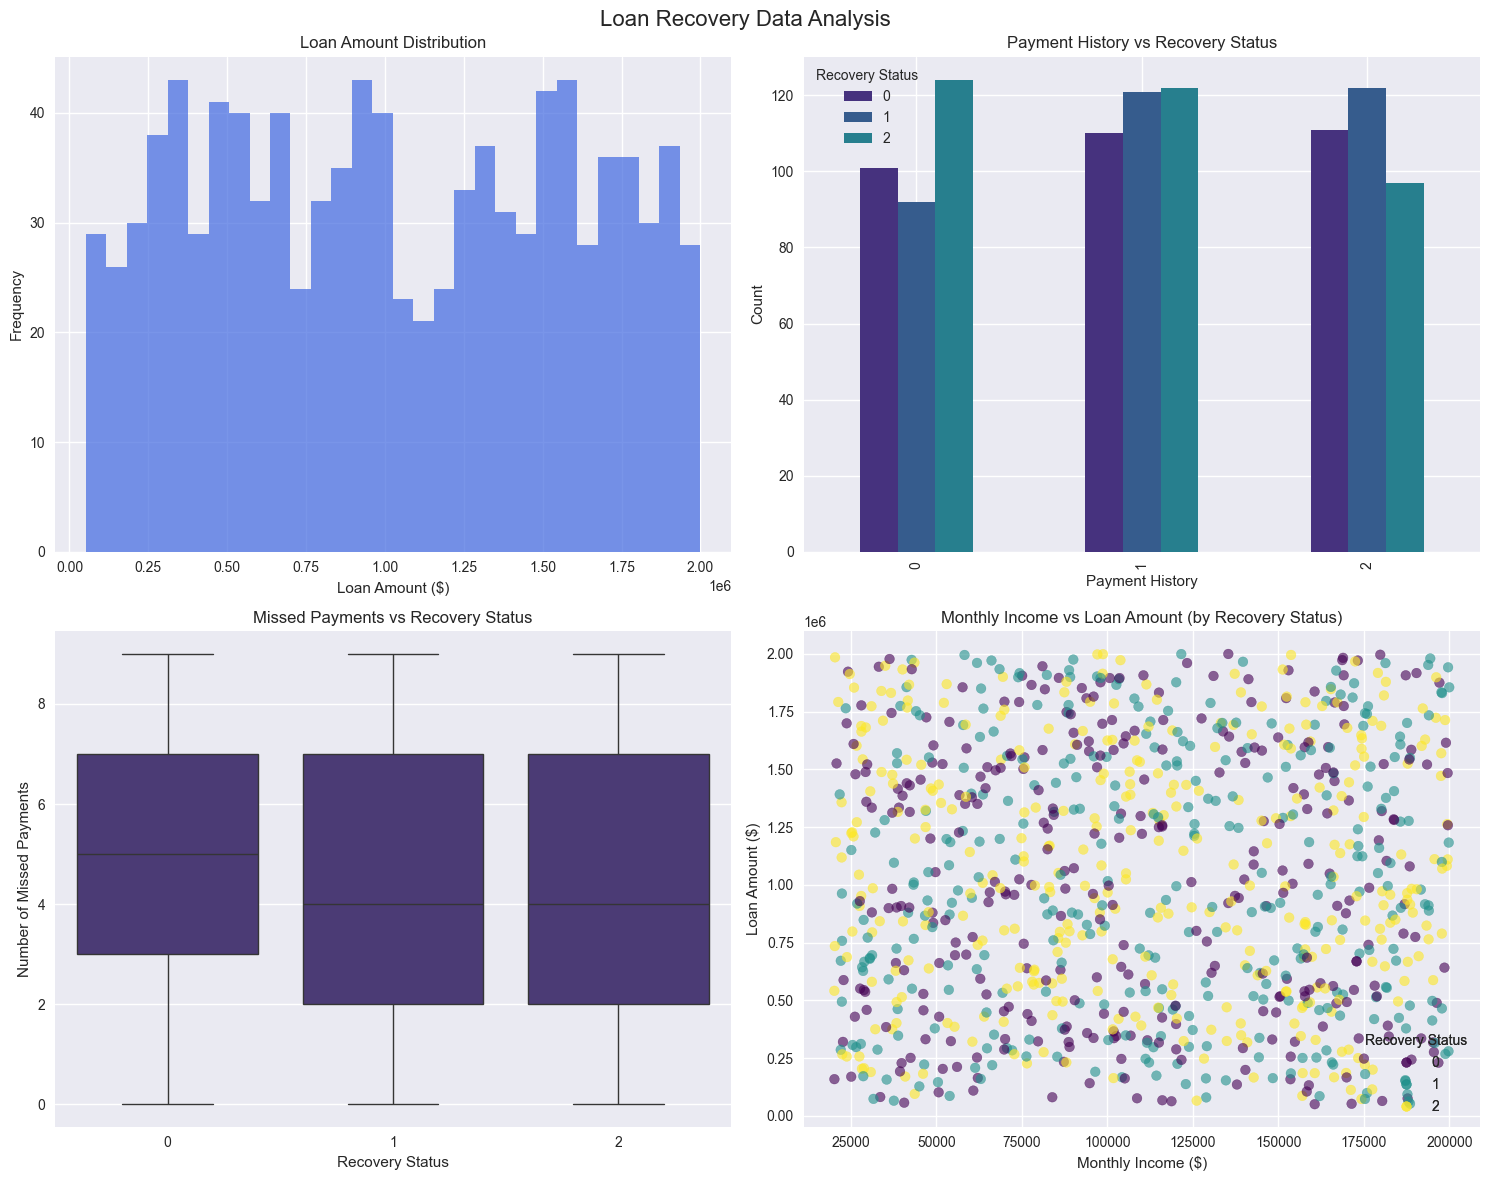

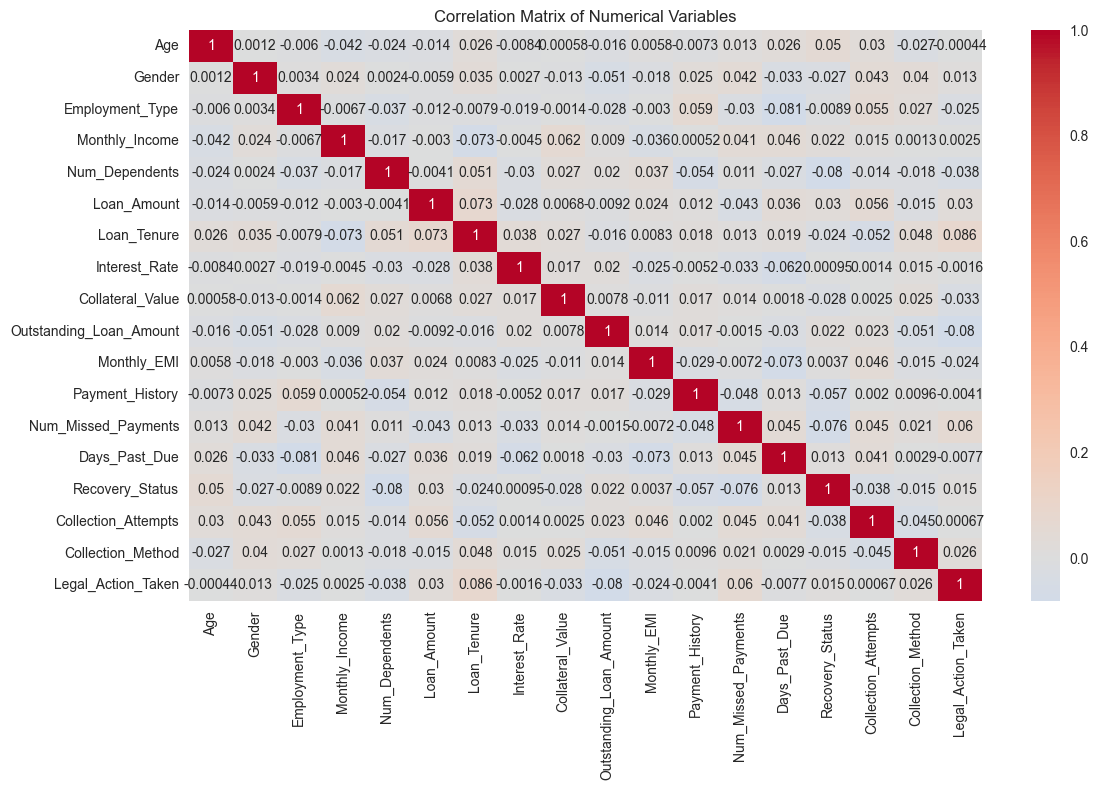


4. Segmenting borrowers...
Segmenting borrowers using K-Means clustering...


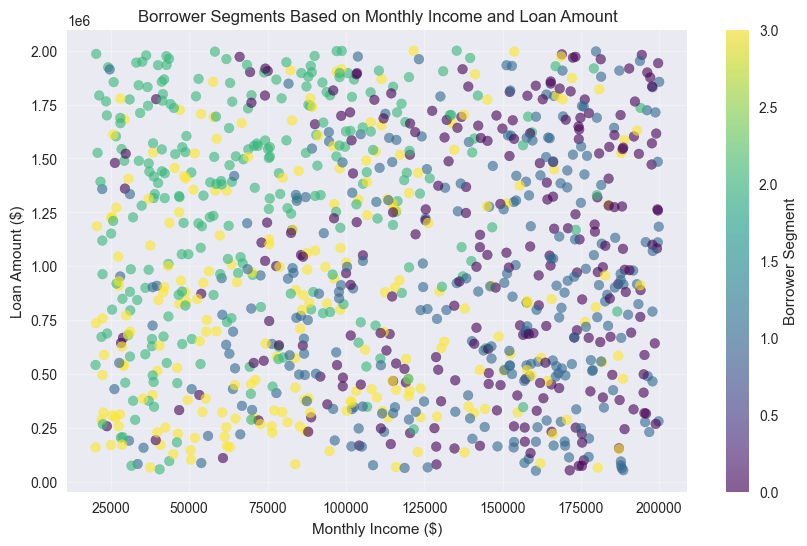

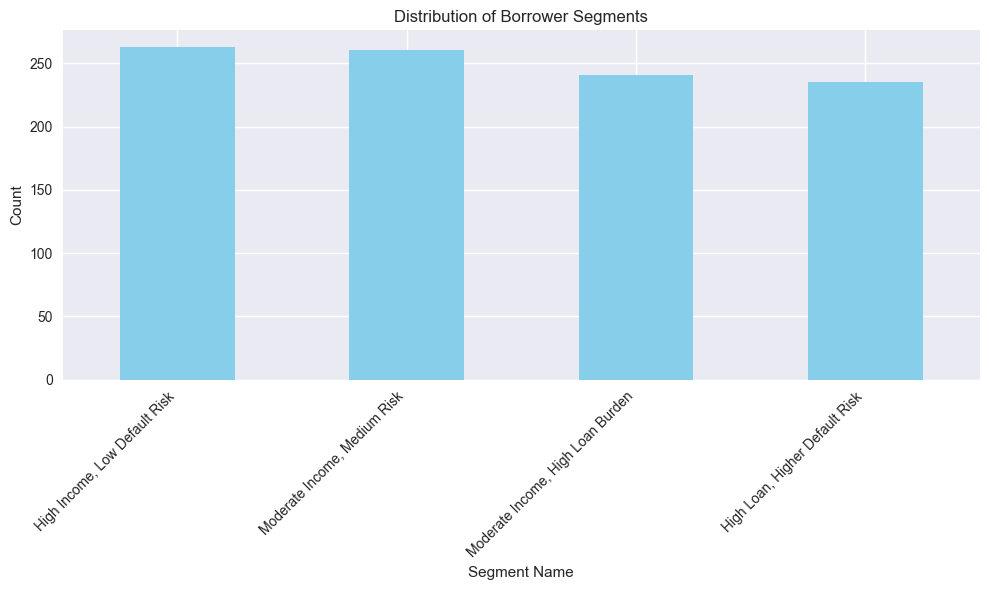


5. Training machine learning model...
Training machine learning model...
Model Accuracy: 0.8700

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       105
           1       0.93      0.79      0.85        95

    accuracy                           0.87       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.87      0.87       200



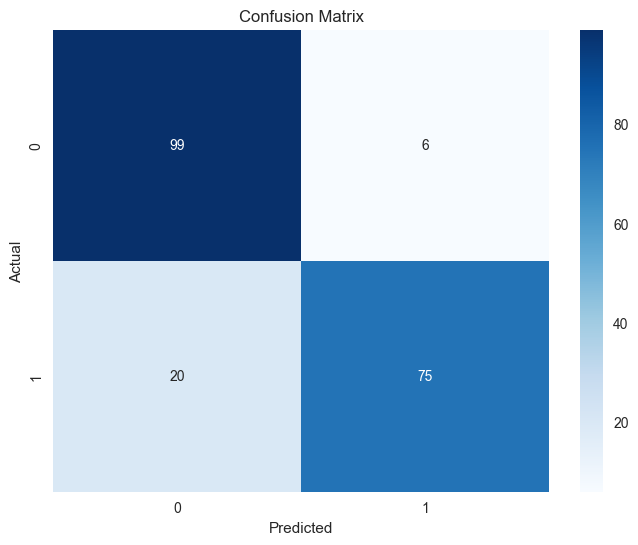


Feature Importance:
                    feature  importance
7               Monthly_EMI    0.324894
9             Days_Past_Due    0.108545
4             Interest_Rate    0.083964
1            Monthly_Income    0.082652
5          Collateral_Value    0.078046
8       Num_Missed_Payments    0.075881
2               Loan_Amount    0.069155
6   Outstanding_Loan_Amount    0.064300
3               Loan_Tenure    0.052290
0                       Age    0.047140
10          Payment_History    0.013134


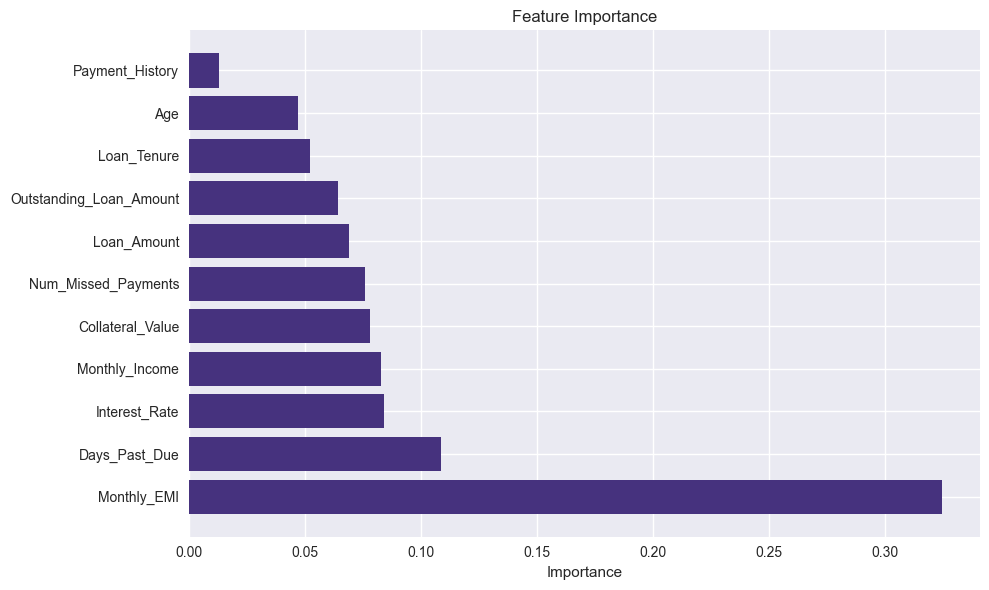


6. Assigning recovery strategies...
Assigning recovery strategies based on risk scores...


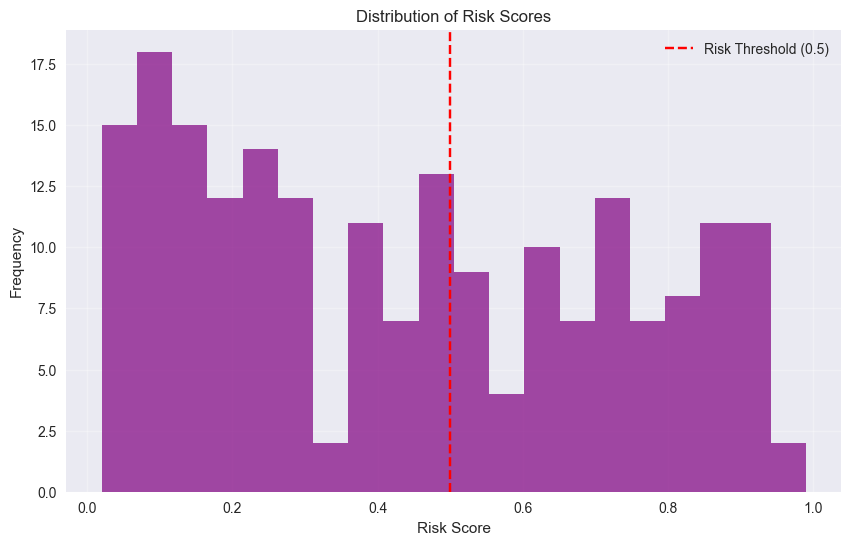

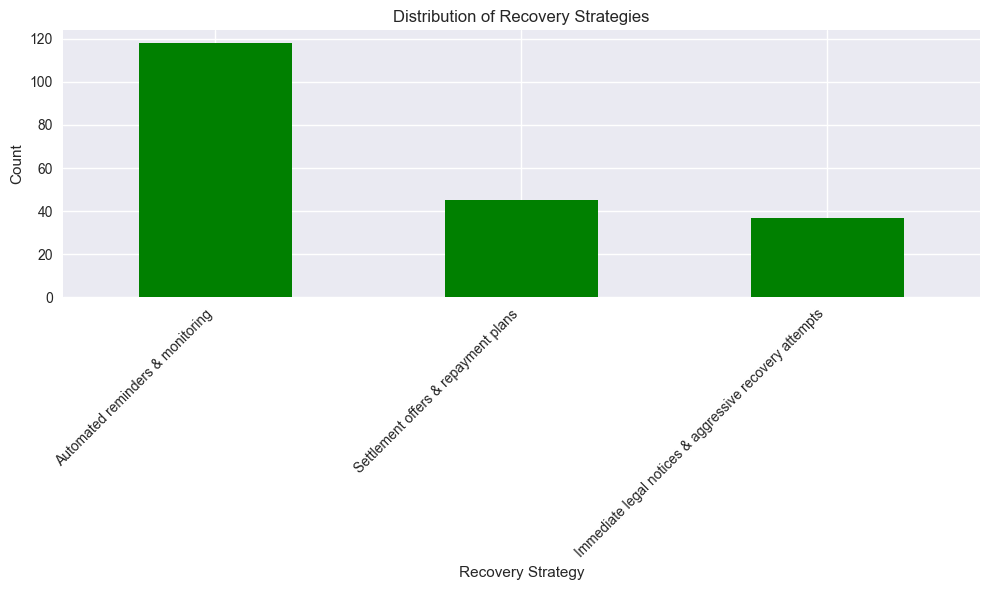


Sample recovery strategies:
    Borrower_ID  Risk_Score  Predicted_High_Risk  \
812     BRW_812        0.89                    1   
339     BRW_339        0.52                    1   
732     BRW_732        0.53                    1   
514     BRW_514        0.09                    0   
556     BRW_556        0.70                    1   
570     BRW_570        0.72                    1   
321     BRW_321        0.79                    1   
710     BRW_710        0.19                    0   
997     BRW_997        0.14                    0   
325     BRW_325        0.20                    0   

                                     Recovery_Strategy  
812  Immediate legal notices & aggressive recovery ...  
339                Settlement offers & repayment plans  
732                Settlement offers & repayment plans  
514                   Automated reminders & monitoring  
556                Settlement offers & repayment plans  
570                Settlement offers & repayment plans  

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# Load the dataset
def load_data(file_path):
    """Load the loan recovery dataset"""
    # For demonstration, let's create a sample dataset if the file doesn't exist
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File {file_path} not found. Creating sample data for demonstration.")
        np.random.seed(42)
        n_samples = 1000
        
        data = {
            'Borrower_ID': [f'BRW_{i}' for i in range(n_samples)],
            'Age': np.random.randint(20, 70, n_samples),
            'Gender': np.random.choice(['Male', 'Female'], n_samples),
            'Employment_Type': np.random.choice(['Salaried', 'Self-Employed', 'Business'], n_samples),
            'Monthly_Income': np.random.randint(20000, 200000, n_samples),
            'Num_Dependents': np.random.randint(0, 5, n_samples),
            'Loan_ID': [f'LN_{i}' for i in range(n_samples)],
            'Loan_Amount': np.random.randint(50000, 2000000, n_samples),
            'Loan_Tenure': np.random.randint(12, 84, n_samples),
            'Interest_Rate': np.random.uniform(7, 18, n_samples),
            'Collateral_Value': np.random.randint(0, 2500000, n_samples),
            'Outstanding_Loan_Amount': np.random.randint(0, 1000000, n_samples),
            'Monthly_EMI': np.random.randint(1000, 50000, n_samples),
            'Payment_History': np.random.choice(['On-Time', 'Delayed', 'Missed'], n_samples),
            'Num_Missed_Payments': np.random.randint(0, 10, n_samples),
            'Days_Past_Due': np.random.randint(0, 180, n_samples),
            'Recovery_Status': np.random.choice(['Fully Recovered', 'Partially Recovered', 'Not Recovered'], n_samples),
            'Collection_Attempts': np.random.randint(0, 10, n_samples),
            'Collection_Method': np.random.choice(['Calls', 'Emails', 'Settlement Offer', 'Legal Notice', 'Debt Collectors'], n_samples),
            'Legal_Action_Taken': np.random.choice(['Yes', 'No'], n_samples)
        }
        
        df = pd.DataFrame(data)
        df.to_csv('sample_loan_data.csv', index=False)
        print("Sample data created and saved as 'sample_loan_data.csv'")
    
    return df

# Data preprocessing
def preprocess_data(df):
    """Preprocess the data: handle missing values, encode categorical variables"""
    # Make a copy of the dataframe
    df_processed = df.copy()
    
    # Handle missing values if any
    if df_processed.isnull().sum().any():
        print("Handling missing values...")
        # Fill numerical missing values with median
        num_cols = df_processed.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        
        # Fill categorical missing values with mode
        cat_cols = df_processed.select_dtypes(include=['object']).columns
        for col in cat_cols:
            if col != 'Borrower_ID' and col != 'Loan_ID':
                df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
    
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['Gender', 'Employment_Type', 'Payment_History', 
                        'Recovery_Status', 'Collection_Method', 'Legal_Action_Taken']
    
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
    
    return df_processed, label_encoders

# Exploratory Data Analysis
def perform_eda(df):
    """Perform exploratory data analysis and generate visualizations"""
    
    print("Performing exploratory data analysis...")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Loan Recovery Data Analysis', fontsize=16)
    
    # Loan Amount Distribution
    axes[0, 0].hist(df['Loan_Amount'], bins=30, alpha=0.7, color='royalblue')
    axes[0, 0].set_title('Loan Amount Distribution')
    axes[0, 0].set_xlabel('Loan Amount ($)')
    axes[0, 0].set_ylabel('Frequency')
    
    # Payment History vs Recovery Status
    recovery_by_payment = pd.crosstab(df['Payment_History'], df['Recovery_Status'])
    recovery_by_payment.plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Payment History vs Recovery Status')
    axes[0, 1].set_xlabel('Payment History')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend(title='Recovery Status')
    
    # Missed Payments vs Recovery Status
    sns.boxplot(x='Recovery_Status', y='Num_Missed_Payments', data=df, ax=axes[1, 0])
    axes[1, 0].set_title('Missed Payments vs Recovery Status')
    axes[1, 0].set_xlabel('Recovery Status')
    axes[1, 0].set_ylabel('Number of Missed Payments')
    
    # Monthly Income vs Loan Amount colored by Recovery Status
    scatter = axes[1, 1].scatter(df['Monthly_Income'], df['Loan_Amount'], 
                                 c=df['Recovery_Status'], alpha=0.6, cmap='viridis')
    axes[1, 1].set_title('Monthly Income vs Loan Amount (by Recovery Status)')
    axes[1, 1].set_xlabel('Monthly Income ($)')
    axes[1, 1].set_ylabel('Loan Amount ($)')
    legend = axes[1, 1].legend(*scatter.legend_elements(), title="Recovery Status")
    axes[1, 1].add_artist(legend)
    
    plt.tight_layout()
    plt.savefig('loan_recovery_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Borrower segmentation using K-Means
def segment_borrowers(df, n_clusters=4):
    """Segment borrowers into clusters using K-Means"""
    
    print("Segmenting borrowers using K-Means clustering...")
    
    features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
                'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 
                'Num_Missed_Payments', 'Days_Past_Due']
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['Borrower_Segment'] = kmeans.fit_predict(df_scaled)
    
    # Name the segments
    df['Segment_Name'] = df['Borrower_Segment'].map({
        0: 'Moderate Income, High Loan Burden',
        1: 'High Income, Low Default Risk',
        2: 'Moderate Income, Medium Risk',
        3: 'High Loan, Higher Default Risk'
    })
    
    # Visualize segments
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['Monthly_Income'], df['Loan_Amount'], 
                         c=df['Borrower_Segment'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Borrower Segment')
    plt.title('Borrower Segments Based on Monthly Income and Loan Amount')
    plt.xlabel('Monthly Income ($)')
    plt.ylabel('Loan Amount ($)')
    plt.grid(True, alpha=0.3)
    plt.savefig('borrower_segments.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Segment distribution
    segment_counts = df['Segment_Name'].value_counts()
    plt.figure(figsize=(10, 6))
    segment_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Borrower Segments')
    plt.xlabel('Segment Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('segment_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

# Train the machine learning model
def train_model(df):
    """Train a Random Forest model to predict high-risk borrowers"""
    
    print("Training machine learning model...")
    
    # Create high-risk flag based on segments
    df['High_Risk_Flag'] = df['Segment_Name'].apply(
        lambda x: 1 if x in ['High Loan, Higher Default Risk', 'Moderate Income, High Loan Burden'] else 0)
    
    # Select features for the model
    features = ['Age', 'Monthly_Income', 'Loan_Amount', 'Loan_Tenure', 'Interest_Rate',
                'Collateral_Value', 'Outstanding_Loan_Amount', 'Monthly_EMI', 
                'Num_Missed_Payments', 'Days_Past_Due', 'Payment_History']
    
    X = df[features]
    y = df['High_Risk_Flag']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train the model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return rf_model, X_test, y_test, accuracy, feature_importance

# Assign recovery strategies based on risk scores
def assign_recovery_strategies(model, X_test, df):
    """Assign recovery strategies based on risk scores"""
    
    print("Assigning recovery strategies based on risk scores...")
    
    # Get risk scores (probability of being high risk)
    risk_scores = model.predict_proba(X_test)[:, 1]
    
    # Create a test dataframe with risk scores
    df_test = X_test.copy()
    df_test['Risk_Score'] = risk_scores
    df_test['Predicted_High_Risk'] = (df_test['Risk_Score'] > 0.5).astype(int)
    
    # Merge with original data to get borrower details
    borrower_details = df[['Borrower_ID', 'Segment_Name', 'Recovery_Status', 
                          'Collection_Method', 'Collection_Attempts', 'Legal_Action_Taken']]
    df_test = df_test.merge(borrower_details, left_index=True, right_index=True, how='left')
    
    # Define recovery strategy function
    def get_recovery_strategy(risk_score):
        if risk_score > 0.75:
            return "Immediate legal notices & aggressive recovery attempts"
        elif 0.50 <= risk_score <= 0.75:
            return "Settlement offers & repayment plans"
        else:
            return "Automated reminders & monitoring"
    
    # Assign recovery strategies
    df_test['Recovery_Strategy'] = df_test['Risk_Score'].apply(get_recovery_strategy)
    
    # Visualize risk score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df_test['Risk_Score'], bins=20, alpha=0.7, color='purple')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Risk Threshold (0.5)')
    plt.title('Distribution of Risk Scores')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('risk_score_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Recovery strategy distribution
    strategy_counts = df_test['Recovery_Strategy'].value_counts()
    plt.figure(figsize=(10, 6))
    strategy_counts.plot(kind='bar', color='green')
    plt.title('Distribution of Recovery Strategies')
    plt.xlabel('Recovery Strategy')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('recovery_strategy_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_test

# Save the model and encoders for deployment
def save_artifacts(model, label_encoders, file_paths):
    """Save the trained model and label encoders for deployment"""
    
    # Save the model
    with open(file_paths['model'], 'wb') as f:
        pickle.dump(model, f)
    
    # Save the label encoders
    with open(file_paths['encoders'], 'wb') as f:
        pickle.dump(label_encoders, f)
    
    print(f"Model saved to {file_paths['model']}")
    print(f"Label encoders saved to {file_paths['encoders']}")

# Main function to run the entire pipeline
def main():
    """Main function to run the complete loan recovery system pipeline"""
    
    print("=" * 60)
    print("SMART LOAN RECOVERY SYSTEM")
    print("=" * 60)
    
    # Load the data
    print("\n1. Loading data...")
    df = load_data("loan_recovery.csv")
    
    # Display basic info about the dataset
    print(f"Dataset shape: {df.shape}")
    print("\nDataset columns:")
    print(df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Preprocess the data
    print("\n2. Preprocessing data...")
    df_processed, label_encoders = preprocess_data(df)
    
    # Perform EDA
    print("\n3. Performing exploratory data analysis...")
    perform_eda(df_processed)
    
    # Segment borrowers
    print("\n4. Segmenting borrowers...")
    df_segmented = segment_borrowers(df_processed)
    
    # Train the model
    print("\n5. Training machine learning model...")
    model, X_test, y_test, accuracy, feature_importance = train_model(df_segmented)
    
    # Assign recovery strategies
    print("\n6. Assigning recovery strategies...")
    recovery_strategies = assign_recovery_strategies(model, X_test, df_segmented)
    
    # Display sample results
    print("\nSample recovery strategies:")
    print(recovery_strategies[['Borrower_ID', 'Risk_Score', 'Predicted_High_Risk', 'Recovery_Strategy']].head(10))
    
    # Save artifacts for deployment
    print("\n7. Saving artifacts for deployment...")
    save_artifacts(model, label_encoders, {
        'model': 'loan_recovery_model.pkl',
        'encoders': 'label_encoders.pkl'
    })
    
    # Save the results
    recovery_strategies.to_csv('recovery_strategies.csv', index=False)
    print("Recovery strategies saved to 'recovery_strategies.csv'")
    
    print("\n" + "=" * 60)
    print("Loan recovery system pipeline completed successfully!")
    print("=" * 60)
    
    return model, df_segmented, recovery_strategies

# Run the main function if this script is executed
if __name__ == "__main__":
    model, df, strategies = main()